In [1]:
import scipy
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
from functools import partial
# from NeuralNet import *
from timeit import default_timer

from Solver import *
import sys
sys.path.append('../Utility')
import PlotDefault
import NeuralNet
from Numerics import gradient_first


# Load data

In [2]:
N_y = 384
beta = 1.0
tau_inv = [0.01, 0.02, 0.04, 0.08, 0.16]
N_data = len(tau_inv)
data_dirs = ["../data/beta_1.0_Gamma_1.0_relax_" + str(tau_inv[i]) + "/" for i in range(len(tau_inv))]

N_data = len(data_dirs)
closure_mean,  q_mean, dq_dy_mean = np.zeros((N_data,N_y)), np.zeros((N_data,N_y)), np.zeros((N_data,N_y))
for i in range(N_data):  
    closure_mean[i, :], q_mean[i, :], dq_dy_mean[i, :] = load_data(data_dirs[i])

L = 4*np.pi
yy = np.linspace(-L/2.0, L/2.0, N_y)
dy = yy[1] - yy[0]

omega_jet = np.zeros(N_y)
omega_jet[0:N_y//2] = 1.0
omega_jet[N_y//2:N_y] = -1.0
q_jet = omega_jet + beta*yy


# TODO: clean data
chop_l = 50
for i in range(N_data):  
    q_mean[i, 0:chop_l] = np.linspace(q_jet[0],   q_mean[i,chop_l-1],  chop_l)   #q_jet[0:chop_l]
    q_mean[i, -chop_l:] = np.linspace(q_mean[i, -chop_l], q_jet[-1],  chop_l)    #q_jet[-chop_l:] 
    dq_dy_mean[i, 0:chop_l] = np.linspace(beta, dq_dy_mean[i,chop_l-1],  chop_l)
    dq_dy_mean[i, -chop_l:] = np.linspace(dq_dy_mean[i, -chop_l], beta, chop_l)
    
q_mean_abs = np.fabs(q_mean)  
mu_f = closure_mean/dq_dy_mean

# TODO: clip and filter the data
mu_f[mu_f >= 0.1 ] = 0.0
mu_f[mu_f <= 0.0 ] = 0.0
for i in range(N_data):
    mu_f[i,:] = scipy.ndimage.gaussian_filter1d(mu_f[i,:], 5)


# Visualize data

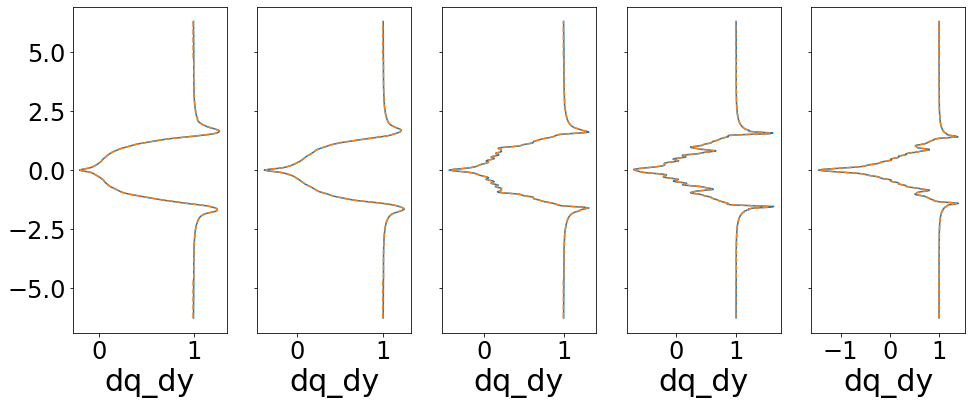

In [3]:
# compare dq_dy_mean vs dq_dy
dq_mean_dy = np.zeros(dq_dy_mean.shape)
for i in range(N_data): 
    dq_mean_dy[i, :] = gradient_first(q_mean[i, :], dy, bc = "one-sided")

fig, ax = plt.subplots(nrows=1, ncols=N_data, sharex=False, sharey=True, figsize=(16,6))
for i in range(N_data):
    ax[i].plot(dq_dy_mean[i,:], yy)
    ax[i].plot(dq_mean_dy[i,:], yy, "--")
    ax[i].set_xlabel("dq_dy")
    

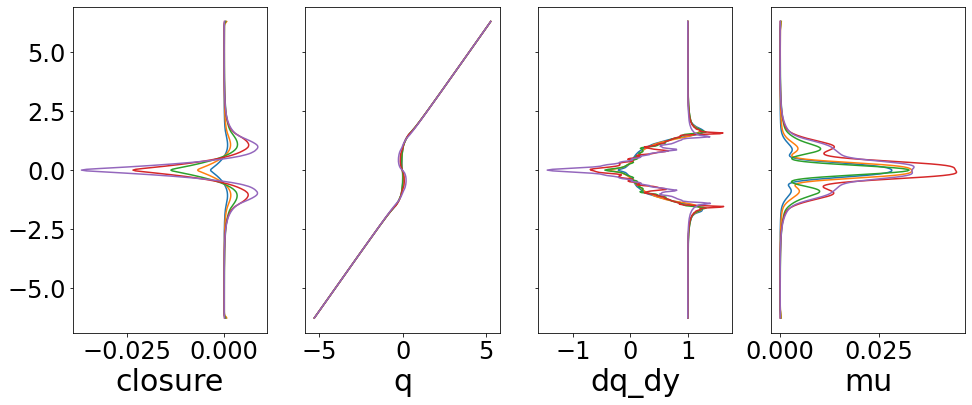

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=True, figsize=(16,6))
for i in range(N_data):
    ax[0].plot(closure_mean[i,:], yy)
    ax[1].plot(q_mean[i,:], yy)
    ax[2].plot(dq_dy_mean[i,:], yy)
    ax[3].plot(mu_f[i,:], yy)
    
    ax[0].set_xlabel("closure")
    ax[1].set_xlabel("q")
    ax[2].set_xlabel("dq_dy")
    ax[3].set_xlabel("mu")


In [ ]:
nn_save_name = "direct.nn"
x_train = torch.from_numpy(np.stack((q_mean_abs.flatten(), dq_dy_mean.flatten())).T.astype(np.float32)) 
y_train = torch.from_numpy(mu_f.flatten()[:,np.newaxis].astype(np.float32))/mu_scale

ind = x_train.shape[1]
outd = y_train.shape[1] 

learning_rate = 0.001
step_size = 10000
gamma = 0.1  
epochs = 50000
batch_size = 1024 #64


torch.manual_seed(0)


net = NeuralNet.FNN(ind, outd, layers, width, activation, initializer, outputlayer) 
optimizer = NeuralNet.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
myloss = torch.nn.MSELoss(reduction='sum')
t0 = default_timer()

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
for ep in range(epochs):
    net.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        
        optimizer.zero_grad()
        
        out = net(x)
        loss = myloss(out , y)*1000
        loss.backward()
        
        optimizer.step()
        train_l2 += loss.item()

# TODO reducing learning rate 
#     scheduler.step()

    if ep % 1000 == 0:
        # train_l2/= ntrain
        t2 = default_timer()
        print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)
        if nn_save_name is not None:
            torch.save(net, nn_save_name)
        
       

Epoch :  0  Epoch time :  0.4417786980047822  Train L2 Loss :  112476.15625
Epoch :  1000  Epoch time :  0.5445387719664723  Train L2 Loss :  3036.7515869140625
Epoch :  2000  Epoch time :  0.5939162459690124  Train L2 Loss :  2723.566650390625
